In [1]:
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from nltk.stem import PorterStemmer
from sklearn.externals import joblib 
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances

import imp
import copy
import pickle
import multiprocessing

import numpy as np
import pandas as pd
import utils as my_utils
import ELJST_script_BTM as lda
import matplotlib.pyplot as plt

/home/william18026/.conda/envs/python3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
min_df = 5
max_df = .5
cutoff = 0.35
title = "electronics_glove_random_500"

maxIters = 5

beta = .01
gamma = 10
n_topics = 5
n_sentiment = 5
lambda_param = 1.0

In [3]:
dataset = pd.read_pickle("resources/"+ title + "_" + str(cutoff) + "_dataset")

In [4]:
similar_words = pickle.load(open("resources/"+ title + "_" + str(cutoff) + ".pickle","rb"))

In [5]:
len(similar_words)

500

In [6]:
alpha = 0.1/n_topics * np.ones(n_topics)
gamma = [gamma/(n_topics*n_sentiment)]*n_sentiment

In [7]:
imp.reload(lda)

<module 'ELJST_script_BTM' from '/home/william18026/Embedding-LJST/ELJST_script_BTM.py'>

In [8]:
sampler = lda.SentimentLDAGibbsSampler(n_topics, alpha, beta, gamma, numSentiments=n_sentiment, minlabel = 0, 
                                       maxlabel = 5, SentimentRange = 5, max_df = max_df, min_df = min_df, 
                                       lambda_param = lambda_param)

In [9]:
%%time
sampler._initialize_(reviews = dataset.text.tolist(), labels = dataset.overall.tolist(), skipgramwindow=5)

CPU times: user 7.9 s, sys: 128 ms, total: 8.03 s
Wall time: 7.96 s


In [10]:
sampler.numbigrams

131535

In [11]:
sampler.run(reviews=dataset.text.tolist(), labels=dataset.overall.tolist(), 
            similar_words=similar_words, mrf=False, maxIters=maxIters)

  1%|          | 3/500 [00:00<00:30, 16.41it/s]

Starting iteration 1 of 5


  1%|          | 3/500 [00:00<00:44, 11.15it/s]

Starting iteration 2 of 5


  1%|          | 3/500 [00:00<00:32, 15.22it/s]

Starting iteration 3 of 5


  0%|          | 0/500 [00:00<?, ?it/s]

Starting iteration 4 of 5


  0%|          | 0/500 [00:00<?, ?it/s]

Starting iteration 5 of 5


100%|██████████| 500/500 [00:11<00:00, 44.44it/s]


# Evaluations

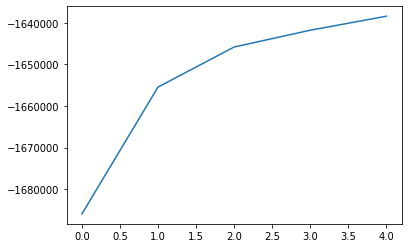

In [12]:
plt.plot(sampler.loglikelihood_history)

In [13]:
silhouette_score(euclidean_distances(sampler.wordOccuranceMatrix),
                 sampler.dt_distribution.argmax(axis=1), metric='precomputed')

-0.03173021322226996

In [14]:
davies_bouldin_score(sampler.wordOccuranceMatrix, sampler.dt_distribution.argmax(axis=1))

12.195141386129688

In [15]:
my_utils.coherence_score(sampler.wordOccuranceMatrix, list(sampler.getTopKWords(5).values()), sampler.vocabulary)

-13.60035396574704

In [16]:
%%time
my_utils.get_hscore_multi(sampler.dt_distribution, sampler.wordOccuranceMatrix, n_topics, 500)

CPU times: user 1.63 s, sys: 573 ms, total: 2.21 s
Wall time: 2.13 s


0.04726621145602166

In [17]:
sampler.loglikelihood()

-1638392.0376346912

In [18]:
sampler.perplexity()

16856.019491368374

## Appendix

In [ ]:
# joblib.dump(sampler, "resources/BTM_sampler_0.4_1")